# Tiền xử lý dữ liệu aptos2019-blindness-detection cho hệ thống chẩn đoán bệnh võng mạc tiểu đường

Notebook này hướng dẫn các bước tiền xử lý dữ liệu ảnh đáy mắt cho bài toán phân loại, phân đoạn và học nhúng ảnh võng mạc tiểu đường.

In [3]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
    --------------------------------------- 0.8/39.0 MB 8.5 MB/s eta 0:00:05
   --------- ------------------------------ 8.9/39.0 MB 32.6 MB/s eta 0:00:01
   ------------------ --------------------- 18.4/39.0 MB 37.4 MB/s eta 0:00:01
   -------------------------- ------------- 26.0/39.0 MB 37.4 MB/s eta 0:00:01
   ------------------------------ --------- 29.4/39.0 MB 33.3 MB/s eta 0:00:01
   ------------------------------------ --- 35.9/39.0 MB 32.1 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 31.8 MB/s eta 0:00:00


In [5]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [6]:
# Nhập các thư viện cần thiết
import os
import zipfile
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image

## 1. Giải nén dữ liệu và đọc file nhãn
Giải nén file zip, đọc file CSV nhãn để chuẩn bị cho các bước tiền xử lý tiếp theo.

In [7]:
# Đường dẫn file zip và thư mục lưu ảnh đã giải nén
zip_path = 'aptos2019-blindness-detection.zip'
extract_dir = 'aptos2019'
processed_dir = 'processed_images'
os.makedirs(processed_dir, exist_ok=True)

# Giải nén dữ liệu
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Đọc file nhãn
train_csv = os.path.join(extract_dir, 'train.csv')
df = pd.read_csv(train_csv)
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


## 2. Tiền xử lý ảnh: resize, cân bằng sáng, crop optic disc
Thực hiện các bước tiền xử lý cơ bản cho ảnh đáy mắt: resize về kích thước chuẩn, cân bằng ánh sáng (CLAHE), crop optic disc (giả định ảnh đã centered).

In [8]:
def preprocess_image(img_path, desired_size=224):
    # Đọc ảnh
    img = cv2.imread(img_path)
    if img is None:
        return None
    # Resize
    img = cv2.resize(img, (desired_size, desired_size))
    # Cân bằng ánh sáng (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    # Crop optic disc (giả định ảnh đã centered, crop hình tròn)
    h, w, _ = img.shape
    mask = np.zeros((h, w), np.uint8)
    cv2.circle(mask, (w//2, h//2), int(0.9*w//2), 1, -1)
    img = cv2.bitwise_and(img, img, mask=mask)
    # Chuẩn hóa pixel
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), desired_size/30), -4, 128)
    return img

## 3. Áp dụng tiền xử lý cho toàn bộ tập ảnh và lưu kết quả
Tiền xử lý toàn bộ ảnh train, lưu ảnh đã xử lý vào thư mục mới để phục vụ huấn luyện các mô hình phân loại, phân đoạn, học nhúng.

In [9]:
image_folder = os.path.join(extract_dir, 'train_images')
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_id = row['id_code']
    img_path = os.path.join(image_folder, f"{img_id}.png")
    img = preprocess_image(img_path, desired_size=224)
    if img is not None:
        cv2.imwrite(os.path.join(processed_dir, f"{img_id}.png"), img)
print("Tiền xử lý hoàn tất. Ảnh đã lưu tại:", processed_dir)

100%|██████████| 3662/3662 [04:06<00:00, 14.85it/s]

Tiền xử lý hoàn tất. Ảnh đã lưu tại: processed_images


## 4. Tiền xử lý nâng cao: kiểm tra ảnh lỗi, chuẩn hóa pixel, tăng cường dữ liệu, cân bằng lớp
Các bước này giúp tăng chất lượng dữ liệu đầu vào cho mô hình deep learning y tế.

In [10]:
# Kiểm tra và loại bỏ ảnh lỗi, ảnh quá tối/mờ
def is_valid_image(img, threshold_brightness=10, threshold_blur=10):
    if img is None:
        return False
    # Kiểm tra độ sáng trung bình
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    # Kiểm tra độ mờ (variance of Laplacian)
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()
    return brightness > threshold_brightness and blur > threshold_blur

# Ví dụ sử dụng:
# img = cv2.imread('path_to_image.png')
# if is_valid_image(img):
#     ...

In [11]:
# Chuẩn hóa pixel về [0,1]
def normalize_image(img):
    return img.astype(np.float32) / 255.0

# Ví dụ sử dụng:
# img = preprocess_image(path)
# img = normalize_image(img)

In [12]:
# Tăng cường dữ liệu (augmentation) cơ bản
import random

def augment_image(img):
    # Xoay ngẫu nhiên
    angle = random.choice([0, 90, 180, 270])
    if angle != 0:
        img = cv2.rotate(img, {90: cv2.ROTATE_90_CLOCKWISE, 180: cv2.ROTATE_180, 270: cv2.ROTATE_90_COUNTERCLOCKWISE}[angle])
    # Lật ngang ngẫu nhiên
    if random.random() > 0.5:
        img = cv2.flip(img, 1)
    # Thay đổi độ sáng ngẫu nhiên
    value = random.randint(-30, 30)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = np.clip(v + value, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2BGR)
    return img

# Ví dụ sử dụng:
# img_aug = augment_image(img)

In [13]:
# Cân bằng số lượng mẫu giữa các lớp bằng augmentation cho lớp thiểu số
def balance_classes(df, processed_dir, target_col='diagnosis', min_samples=1000):
    class_counts = df[target_col].value_counts()
    for cls, count in class_counts.items():
        if count < min_samples:
            samples_needed = min_samples - count
            samples = df[df[target_col] == cls]['id_code'].tolist()
            for i in range(samples_needed):
                img_id = random.choice(samples)
                img_path = os.path.join(processed_dir, f"{img_id}.png")
                img = cv2.imread(img_path)
                if img is not None:
                    img_aug = augment_image(img)
                    new_id = f"{img_id}_aug{i}"
                    cv2.imwrite(os.path.join(processed_dir, f"{new_id}.png"), img_aug)
    print("Đã cân bằng số lượng mẫu giữa các lớp bằng augmentation.")

# Ví dụ sử dụng:
# balance_classes(df, processed_dir, target_col='diagnosis', min_samples=1000)

## 5. Minh họa trực quan kết quả tiền xử lý ảnh
So sánh ảnh gốc và ảnh sau tiền xử lý để kiểm tra chất lượng và minh họa pipeline.

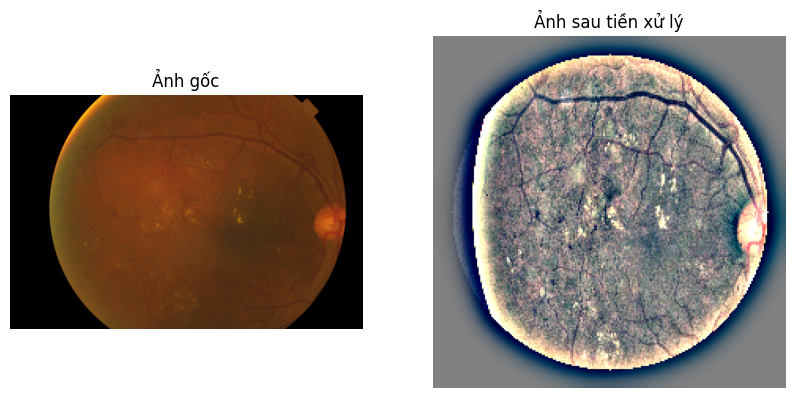

In [14]:
import matplotlib.pyplot as plt

# Chọn một ảnh bất kỳ để minh họa
sample_id = df['id_code'].iloc[0]
img_raw_path = os.path.join(extract_dir, 'train_images', f'{sample_id}.png')
img_processed_path = os.path.join(processed_dir, f'{sample_id}.png')

img_raw = cv2.cvtColor(cv2.imread(img_raw_path), cv2.COLOR_BGR2RGB)
img_processed = cv2.cvtColor(cv2.imread(img_processed_path), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_raw)
plt.title('Ảnh gốc')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_processed)
plt.title('Ảnh sau tiền xử lý')
plt.axis('off')
plt.show()